# Osu taiko playstyle analysis

In [1]:
import os
os.environ['OSUAPIv2_APP_CALLBACK']

'http://localhost:3914/'

In [2]:
# Osu API
from ossapi import *
import os
api = OssapiV2(int(os.environ['OSUAPIv2_APP_ID']), os.environ['OSUAPIv2_APP_SECRET'], os.environ['OSUAPIv2_APP_CALLBACK'])
# apiv1 = Ossapi(os.environ['OSUAPIv1_KEY'])

In [3]:
liemap = api.beatmap(1921771)
print(liemap)

Beatmap(_api=<ossapi.ossapiv2.OssapiV2 object at 0x0000024A2208BB20>, difficulty_rating=6.22, id=1921771, mode=<GameMode.TAIKO: 'taiko'>, status=<RankStatus.LOVED: 4>, total_length=146, version='False', user_id=1980256, beatmapset_id=920188, _beatmapset=Beatmapset(_api=<ossapi.ossapiv2.OssapiV2 object at 0x0000024A2208BB20>, artist='Sakuzyo', artist_unicode='Sakuzyo', covers=Covers(_api=<ossapi.ossapiv2.OssapiV2 object at 0x0000024A2208BB20>, cover='https://assets.ppy.sh/beatmaps/920188/covers/cover.jpg?1622155446', cover_2x='https://assets.ppy.sh/beatmaps/920188/covers/cover@2x.jpg?1622155446', card='https://assets.ppy.sh/beatmaps/920188/covers/card.jpg?1622155446', card_2x='https://assets.ppy.sh/beatmaps/920188/covers/card@2x.jpg?1622155446', list='https://assets.ppy.sh/beatmaps/920188/covers/list.jpg?1622155446', list_2x='https://assets.ppy.sh/beatmaps/920188/covers/list@2x.jpg?1622155446', slimcover='https://assets.ppy.sh/beatmaps/920188/covers/slimcover.jpg?1622155446', slimcover_

In [49]:
# lie = api.beatmap_scores(beatmap_id=1921771, mode="taiko")
# print(lie)

# liev1 = apiv1.get_scores(1921771, mode=1, mods=0, limit=100)
# print(liev1[0].replay_id)
# apiv1.get_replay(beatmap_id = 1921771, user = liev1[0].user_id)

def download_rep(replayID, name = None):
    if name is None:
        name = replayID
    rep = api.session.get(f"{api.BASE_URL}/scores/taiko/{replayID}/download")
    with open(f"replays/{name}.osr", "wb") as f:
        f.write(rep.content)
        
download_rep(168691149)

107.9136690647482
215.8273381294964
0 = KeyTaiko.LEFT_DON
1 = KeyTaiko.LEFT_KAT
2 = KeyTaiko.RIGHT_DON
3 = KeyTaiko.RIGHT_KAT
[[[0.         0.03017521 0.10837119 0.0580561 ]
  [0.00195695 0.         0.06067489 0.2283105 ]
  [0.06457926 0.13919533 0.         0.006197  ]
  [0.1409002  0.12848799 0.03309539 0.        ]]

 [[0.01883239 0.01794872 0.07307692 0.03389831]
  [0.00659134 0.01794872 0.02692308 0.06403013]
  [0.02354049 0.03461538 0.09102564 0.15065913]
  [0.03672316 0.04487179 0.19358974 0.16572505]]]

fast:
[[  0.  93. 334. 178.]
 [  6.   0. 187. 700.]
 [198. 429.   0.  19.]
 [432. 396. 102.   0.]]


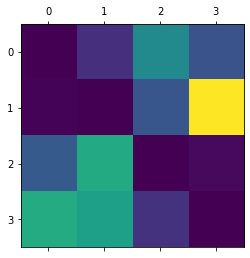


slow:
[[ 20.  14.  57.  36.]
 [  7.  14.  21.  68.]
 [ 25.  27.  71. 160.]
 [ 39.  35. 151. 176.]]


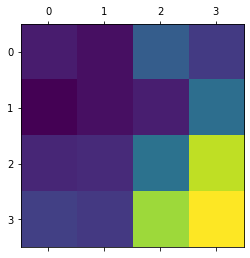

In [446]:
import numpy as np
from osrparse import parse_replay_file, KeyTaiko

# rep = parse_replay_file("replays/168691149.osr")
# rep = parse_replay_file("replays/Edward_Tsui - Hatsune Miku - Talent Shredder [Firce Force] (2021-12-08) Taiko.osr")
# rep = parse_replay_file("replays/Lubei_01 - antiPLUR - Speed of Link [Special] (2021-10-09) Taiko.osr")
BPM = 139

print(60000 / (BPM * 4)) # 1/4s
print(60000 / (BPM * 2)) # 1/2s
slowThreshold = 60000 / (BPM * 4)

for i in range(4):
    print(f"{i} = {str(KeyTaiko(1 << i))}")
    
def swapLdk(arr):
    arr[[0, 1]] = arr[[1, 0]]
    arr[:, [0, 1]] = arr[:, [1, 0]]
    return arr

def normKD(arr):
    sums = arr.sum(axis = 0)
    sum_dons = sums[1] + sums[2]
    sum_kats = sums[0] + sums[3]
    arr = np.copy(arr)
    
    arr[:, 0] /= sum_kats
    arr[:, 1] /= sum_dons
    arr[:, 2] /= sum_dons
    arr[:, 3] /= sum_kats
    return arr

def get_features(rep, slowThreshold):
    
    pressed = KeyTaiko(0)
    timestamp = 0 # Time since previous hit
    prevHit = KeyTaiko(0)

    slow_mat = np.zeros((4,4))
    fast_mat = np.zeros((4,4))

    for hit in rep.play_data:
        newKeys = hit.keys & ~pressed
        pressed = hit.keys
        timestamp += hit.time_delta

        # New hits
        if newKeys != 0:

            # Assign to the array
            prev = np.array([i for i in range(4) if (((1 << i) & prevHit) > 0)], np.int8)
            curr = np.array([i for i in range(4) if (((1 << i) & newKeys) > 0)], np.int8)
            xx, yy = np.meshgrid(prev, curr)

            if timestamp <= slowThreshold:
                fast_mat[xx.flatten(), yy.flatten()] += 1
            else:
                slow_mat[xx.flatten(), yy.flatten()] += 1

            prevHit = newKeys
            timestamp = 0
    
    fast_mat = swapLdk(fast_mat)
    slow_mat = swapLdk(slow_mat)
    
    raw = [fast_mat, slow_mat]
    
    fast_mat = normKD(fast_mat)
    slow_mat = normKD(slow_mat)
    
    fast_norm = fast_mat / np.sum(fast_mat)
    slow_norm = slow_mat / np.sum(slow_mat)
    feat = np.stack([fast_norm, slow_norm], axis = 0).astype(np.float64)
#     feat = fast_mat
#     feat = feat / np.sum(feat)
    
    return feat, raw

download_rep(152963984, "152963984")
rep = parse_replay_file("replays/152963984.osr")
feat, [fast, slow] = get_features(rep, slowThreshold)
print(feat)

print("\nfast:")
print(fast)
plt.matshow(fast)
plt.show()
print("\nslow:")
print(slow)
plt.matshow(slow)
plt.show()

In [322]:
def GetRanking(count = 100, mode = "taiko", country = None):
    
    cnt = 0
    cursor = None
    result = []
    
    while cnt < count:
        r = api.ranking(mode, RankingType.PERFORMANCE, country = country, cursor = cursor)
        cursor = r.cursor
        cnt += len(r.ranking)
        for entry in r.ranking:
            result.append(entry.user)
    
    return result

In [323]:
top1K5 = GetRanking(1500)
CN100 = GetRanking(100, country = "CN")
uniqueIDs = list(set([u.id for u in top1K5] + [u.id for u in CN100]))

In [324]:
uniqueIDs

[8192004,
 10674189,
 7774222,
 9920534,
 10043416,
 12345370,
 15917084,
 9740317,
 2474015,
 2007075,
 13189156,
 2244644,
 6512678,
 6905897,
 13082668,
 7856176,
 81972,
 155707,
 5013564,
 4325444,
 7897156,
 2015300,
 1826898,
 4808796,
 2326627,
 12853352,
 3383404,
 6332530,
 8028288,
 14581894,
 18718856,
 8200331,
 17219727,
 4505744,
 3580055,
 6701207,
 3023007,
 1589409,
 2302140,
 9420989,
 7528639,
 5136582,
 8364237,
 8265940,
 10436827,
 9421030,
 9584873,
 7184619,
 9085164,
 1900787,
 4964596,
 8306932,
 6471926,
 13852925,
 17776893,
 8552710,
 14942478,
 8339729,
 5693717,
 1007896,
 6291741,
 16482594,
 1343783,
 8159528,
 15540527,
 8438068,
 983349,
 10854710,
 2883899,
 2761022,
 14860617,
 3866964,
 3178836,
 17031509,
 21799255,
 7700831,
 15991137,
 7086439,
 13959539,
 426357,
 16056694,
 7364981,
 14041465,
 9503098,
 4407678,
 7160196,
 7479684,
 6447505,
 1483160,
 1581472,
 2277798,
 10625447,
 11764134,
 8593837,
 11002287,
 5136821,
 7692731,
 1088761

In [405]:
import time

# Collect replays
TargetPlayers = [
#     1558839, # betairylia
#     11692528,# Lubei
#     6764344, # Nepoch
#     10324309,# Flandre sca
#     8609627, # Edward
#     10507557,# Hynix
#     3383404, # Rin
#     2221895, # Wonberman
#     12208924,# OvO
#     6443264, # acst
#     9603470, # Yusyou
#     4314222, # Kafuu Cirno
#     609536,  # lzx
    
#     2349769, # kk
#     4315477, # sSSS
#     5310623, # Blastix
#     6294200, # te
#     2073644, # Risona
#     810813,  # HM
    6844521, # szh134
    9383908, # shoucan
    4112195, # 7j
    12480076,# Michael
    11341131,# NaNa
    8263525, # smf
    81972,   # Mic
    15917084,# Apricot L
    12703319,# Minato
    12749779,# Lilia Angel
    16903694,# Pinkiemane
    
    8741695, # syaron
    983349,  # applerss
    6170507, # yu68
    5321719, # uone
    165027,  # Peaceful
    1152851, # Bamgoe
    9912966, # Zeth
    9503098, # hoku
    9864847, # Botched
    7955738, # CL
    13302996,# Boaz
    2865172, # Bries
    11117835,# Quass
    9856910, # Gamelan
    8772103, # nuku
    7740442, # Spartric
    6632605, # Megafan
    14005209,# aquachan
    12611862,# diamond
    933630,  # fanhoho
    6498810, # Kerasi
    3867109, # Maou
    5054081, # rai
    12248285,# Storm
    10530606,# Neon
    10694200,# KD
    15541593,# Dau
    1751879, # shiroino
    11936599,# Quibby
    8770622, # ITGT
    1100246, # DefiantJ
    
    6177263, # mp kick Kasumi-sama
]

def GrabFromBP(uid, amount):
    print("Grab BP maps from uid %d (%s)" % (uid, api.user(uid).username))
    best = api.user_scores(uid, "best", mode = "taiko")[:amount]
    for b in best:
        scoreid = b.id
#         print(b.user().username)
#         print(b.beatmapset.artist)
#         print(b.beatmap.version)
        download_rep(scoreid, f"{b.user().username} - {b.id}")
        time.sleep(15)

In [406]:
GrabFromBP(3716665, 2)

Grab BP maps from uid 3716665 (coed)


In [326]:
from tqdm.notebook import tqdm
# GrabFromBP(TargetPlayers[0], 1)

# for uid in tqdm(uniqueIDs):
#     GrabFromBP(uid, 2)

  0%|          | 0/1567 [00:00<?, ?it/s]

Grab BP maps from uid 8192004 (Y u w a n)
Grab BP maps from uid 10674189 (Kinovia)
Grab BP maps from uid 7774222 (Akonine)
Grab BP maps from uid 9920534 (Rinchoce)
Grab BP maps from uid 10043416 (dihidi)
Grab BP maps from uid 12345370 (Nisoquo)
Grab BP maps from uid 15917084 (Apricot L)
Grab BP maps from uid 9740317 (Asu_Krionat)
Grab BP maps from uid 2474015 (Capu)
Grab BP maps from uid 2007075 (montymintypie)
Grab BP maps from uid 13189156 (Muriy-)
Grab BP maps from uid 2244644 (joel)
Grab BP maps from uid 6512678 (hikiko-)
Grab BP maps from uid 6905897 (-ImojicX)
Grab BP maps from uid 13082668 (Tsubackyy)
Grab BP maps from uid 7856176 (Mashirodayooon)
Grab BP maps from uid 81972 (Mic)
Grab BP maps from uid 155707 (aabc271)
Grab BP maps from uid 5013564 (ayyEve)
Grab BP maps from uid 4325444 (ptar124)
Grab BP maps from uid 7897156 (kobanoir)
Grab BP maps from uid 2015300 (verto)
Grab BP maps from uid 1826898 (ryafka)
Grab BP maps from uid 4808796 (-KalamityStorm-)
Grab BP maps from u

Grab BP maps from uid 2917312 (Jona)
Grab BP maps from uid 263110 (Backfire)
Grab BP maps from uid 6439880 (______________)
Grab BP maps from uid 8987606 (kitafuma)
Grab BP maps from uid 1762267 ([- Maekawa -])
Grab BP maps from uid 9700317 (JFred)
Grab BP maps from uid 1074143 ([TaikoTori])
Grab BP maps from uid 787429 (yuugaras)
Grab BP maps from uid 11437033 (Quloa)
Grab BP maps from uid 9208819 (NanaFlow)
Grab BP maps from uid 1926134 (bvrieivewvw)
Grab BP maps from uid 6349821 (cheese salad)
Grab BP maps from uid 533502 (Konpaku Sariel)
Grab BP maps from uid 5071871 (Jesus)
Grab BP maps from uid 8127489 (karupisuuu)
Grab BP maps from uid 5235718 (Mikudayo)
Grab BP maps from uid 4097035 (Garpo)
Grab BP maps from uid 2229274 (Xytox)
Grab BP maps from uid 12182568 (miyabi3)
Grab BP maps from uid 2073644 (Ookura Risona)
Grab BP maps from uid 1934382 (-NaNdo-)
Grab BP maps from uid 6759472 (dopamineFLOWER)
Grab BP maps from uid 16491572 (Alth)
Grab BP maps from uid 468029 (yyyyyyyyyyyp

Grab BP maps from uid 2615199 (Atreevete)
Grab BP maps from uid 8767392 (ILOVEMARISA)
Grab BP maps from uid 5482401 (iceOC)
Grab BP maps from uid 7432095 (_Infected_)
Grab BP maps from uid 12478373 (TWIL1GHT)
Grab BP maps from uid 845733 (Faputa)
Grab BP maps from uid 13600684 (kdj8381)
Grab BP maps from uid 4949934 (rubies87)
Grab BP maps from uid 1198002 (SpiritsUnite)
Grab BP maps from uid 2435013 (CreepyDuck)
Grab BP maps from uid 1083344 (Koume)
Grab BP maps from uid 14944234 (Hibiki Yuan)
Grab BP maps from uid 9709548 (driodx)
Grab BP maps from uid 3090416 (steven1)
Grab BP maps from uid 6752242 (ZelLink)
Grab BP maps from uid 6506484 (duski)
Grab BP maps from uid 1697789 (itemsgtkpa)
Grab BP maps from uid 9611261 (redbeancola)
Grab BP maps from uid 1271807 (sti)
Grab BP maps from uid 10168328 (Voenkom)
Grab BP maps from uid 9676809 (Nuggets-)
Grab BP maps from uid 6932501 (vun)
Grab BP maps from uid 2131990 (adrien062)
Grab BP maps from uid 16902173 (Suisei_Suki)
Grab BP maps fr

Grab BP maps from uid 9964420 (paz08)
Grab BP maps from uid 6089608 (Shima Rin)
Grab BP maps from uid 961417 (Xayphon)
Grab BP maps from uid 15821708 (Sebola)
Grab BP maps from uid 8833940 (Wilaner)
Grab BP maps from uid 4221845 (Shirai-)
Grab BP maps from uid 6056862 (Yoroiari)
Grab BP maps from uid 1461161 (gyorin)
Grab BP maps from uid 2239411 (Gintoki8)
Grab BP maps from uid 18467765 (kotoma_mf)
Grab BP maps from uid 11430848 (Marksmania)
Grab BP maps from uid 502722 (Cookie_Tree)
Grab BP maps from uid 12749779 ([Lily_White])
Grab BP maps from uid 1764326 (SAWA_PURI)
Grab BP maps from uid 21515245 (yurisyuna_)
Grab BP maps from uid 6835183 (Tsubasa2)
Grab BP maps from uid 8645621 (NomiNomi)
Grab BP maps from uid 2239480 (Raiden)
Grab BP maps from uid 21990398 (MattyIce)
Grab BP maps from uid 216072 (Onion)
Grab BP maps from uid 11619349 (detteiuu)
Grab BP maps from uid 8023063 (Gundham)
Grab BP maps from uid 224280 (Sanjenin Nagi)
Grab BP maps from uid 2771995 (Catgirl)
Grab BP map

Grab BP maps from uid 11276129 (elcho)
Grab BP maps from uid 13291360 (jim-1207)
Grab BP maps from uid 2617190 (mikku1)
Grab BP maps from uid 14225265 (HenNEET)
Grab BP maps from uid 10268533 (Chieri_)
Grab BP maps from uid 16830329 (somebody_33)
Grab BP maps from uid 2781054 (da2b)
Grab BP maps from uid 4337536 (TS_LewisLuo)
Grab BP maps from uid 14356353 (Pineapplerss)
Grab BP maps from uid 8703873 (Myusakura)
Grab BP maps from uid 5820291 (kogachai)
Grab BP maps from uid 11145088 (Clerne)
Grab BP maps from uid 1159051 (abrian)
Grab BP maps from uid 5509009 (Jonah)
Grab BP maps from uid 16846749 (merry08210)
Grab BP maps from uid 4566941 (waisa28)
Grab BP maps from uid 14544810 (xovazka)
Grab BP maps from uid 11931563 (KuroKuroKuro)
Grab BP maps from uid 6418353 (HALCONY)
Grab BP maps from uid 12488630 (yzpineth)
Grab BP maps from uid 4632503 (1RoHa_)
Grab BP maps from uid 2478009 (Kinsuna)
Grab BP maps from uid 8998841 (qqxiaopan)
Grab BP maps from uid 7253958 (Sayira)
Grab BP maps 

Grab BP maps from uid 13898575 (JoJo113)
Grab BP maps from uid 6894424 (Blue06_)
Grab BP maps from uid 1626983 (Cryolien)
Grab BP maps from uid 4002668 (Guabi)
Grab BP maps from uid 1119087 (Soner Wolf)
Grab BP maps from uid 1897332 (lubask)
Grab BP maps from uid 2265974 (wen294)
Grab BP maps from uid 6443899 (Niro-)
Grab BP maps from uid 1602428 (Guardistack-)
Grab BP maps from uid 7746429 (GOLAITHCHAN)
Grab BP maps from uid 7902082 (Hotman)
Grab BP maps from uid 1282954 (Cihyaa)
Grab BP maps from uid 2044810 (Tetsurio)
Grab BP maps from uid 10081162 (Yumi_Hideaki)
Grab BP maps from uid 9008010 (AronMein)
Grab BP maps from uid 5231504 (salakau)
Grab BP maps from uid 4682646 (Max13478)
Grab BP maps from uid 586659 (mliencheng)
Grab BP maps from uid 3044264 (Skull Kid)
Grab BP maps from uid 9950122 (Gtrafh)
Grab BP maps from uid 11334594 (K4L1)
Grab BP maps from uid 7041990 (Chaosfan)
Grab BP maps from uid 8188876 (Naninub)
Grab BP maps from uid 10875855 (Bedwyr Aorta)
Grab BP maps from

Grab BP maps from uid 2250591 (Nikubenki Saya)
Grab BP maps from uid 1980256 (komasy)
Grab BP maps from uid 11392868 (Rabitobi)
Grab BP maps from uid 8263525 (super mario fan)
Grab BP maps from uid 10180454 (Famelira)
Grab BP maps from uid 178038 (Shyguy)
Grab BP maps from uid 21657468 (Mintcream)
Grab BP maps from uid 1259391 (Rosemi Lovelock)
Grab BP maps from uid 259972 (Jakads)
Grab BP maps from uid 17078156 (Kinqko)
Grab BP maps from uid 13563794 (Deli)
Grab BP maps from uid 17373077 (naginagi)
Grab BP maps from uid 8214424 (sighate)
Grab BP maps from uid 3356580 (-byakuya-)
Grab BP maps from uid 1865637 (Vaticser)
Grab BP maps from uid 2283446 (vettel765)
Grab BP maps from uid 12892087 (HarryAda)
Grab BP maps from uid 2537412 (Koucha-)
Grab BP maps from uid 6084548 (tanakaa)
Grab BP maps from uid 11499467 (r1chyy)
Grab BP maps from uid 4601806 (Hana Hayashi)
Grab BP maps from uid 11859926 (Hulk05089)
Grab BP maps from uid 587737 (Zetera)
Grab BP maps from uid 554976 (Myckoll)
Gra

Grab BP maps from uid 14310417 (komugiko31579)
Grab BP maps from uid 7740442 (Spartric)
Grab BP maps from uid 384034 (BrokenArrow)
Grab BP maps from uid 16415779 (Lapina_87)
Grab BP maps from uid 457766 (zx_baka_0502442)
Grab BP maps from uid 6290474 (teamoku)
Grab BP maps from uid 4922419 (Sui za za)
Grab BP maps from uid 10173497 (elahen800)
Grab BP maps from uid 7322682 (Laik4)
Grab BP maps from uid 6372422 (Prymal)
Grab BP maps from uid 7945286 (Hermite)
Grab BP maps from uid 7257168 (VestaraKhai48)
Grab BP maps from uid 8879204 (Majesty Kitsune)
Grab BP maps from uid 9469030 (Setusi)
Grab BP maps from uid 5250153 (alexinet232)
Grab BP maps from uid 1530993 (-xNaCLx-)
Grab BP maps from uid 6757492 (Adimoc)
Grab BP maps from uid 547957 (Zero1519)
Grab BP maps from uid 7715976 (Wariatek)
Grab BP maps from uid 1916043 (39842086)
Grab BP maps from uid 8494233 (Kaemz)
Grab BP maps from uid 695452 (Pitapan)
Grab BP maps from uid 14892190 (Cure)
Grab BP maps from uid 7609510 (Blerargh)
Gr

In [437]:
# Collect features for all replays in folder
features = []

for file in tqdm(os.listdir("replays/")):
    if ".osr" in file:
        rep = parse_replay_file(os.path.join("replays/", file))
        feat, [raw_fast, raw_slow] = get_features(rep, slowThreshold)
        features.append((feat, {'Player': rep.player_name, 'fast': raw_fast, 'slow': raw_slow, 'file': file}))
        
# print(features)

  0%|          | 0/3072 [00:00<?, ?it/s]

In [447]:
import umap
import sklearn

reducer = umap.UMAP()
# reducer = sklearn.decomposition.PCA(n_components = 2)

In [448]:
Xs = [f[0].flatten() for f in features]
Ys = [f[1] for f in features]
emb = reducer.fit_transform(Xs)

In [440]:
import scipy

# https://stackoverflow.com/questions/63812970/scipy-gaussian-kde-matrix-is-not-positive-definite
class GaussianKde(scipy.stats.gaussian_kde):
    """
    Drop-in replacement for gaussian_kde that adds the class attribute EPSILON
    to the covmat eigenvalues, to prevent exceptions due to numerical error.
    """

    EPSILON = 1e-10  # adjust this at will

    def _compute_covariance(self):
        """Computes the covariance matrix for each Gaussian kernel using
        covariance_factor().
        """
        self.factor = self.covariance_factor()
        # Cache covariance and inverse covariance of the data
        if not hasattr(self, '_data_inv_cov'):
            self._data_covariance = np.atleast_2d(np.cov(self.dataset, rowvar=1,
                                                         bias=False,
                                                         aweights=self.weights))
            # we're going the easy way here
            self._data_covariance += self.EPSILON * np.eye(
                len(self._data_covariance))
            self._data_inv_cov = np.linalg.inv(self._data_covariance)

        self.covariance = self._data_covariance * self.factor**2
        self.inv_cov = self._data_inv_cov / self.factor**2
        L = np.linalg.cholesky(self.covariance * 2 * np.pi)
        self._norm_factor = 2*np.log(np.diag(L)).sum()  # needed for scipy 1.5.2
        self.log_det = 2*np.log(np.diag(L)).sum()  # changed var name on 1.6.2

Xs_KDE = np.transpose(np.array(Xs))
print(Xs_KDE.shape)
kernel = GaussianKde(np.unique(Xs_KDE, axis = 1))
# kernel = scipy.stats.gaussian_kde(np.unique(Xs_KDE, axis = 1))

(32, 3070)


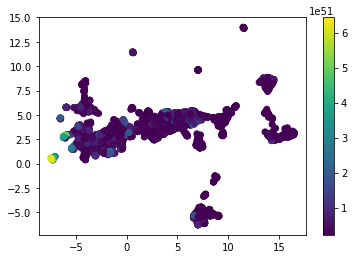

In [449]:
import matplotlib.pyplot as plt

KDEresult = kernel(Xs_KDE)

cb = plt.scatter(emb[:, 0], emb[:, 1], c = KDEresult)
plt.colorbar(cb)

# Numerical issues ?

In [442]:
import matplotlib, random

hex_colors_dic = {}
rgb_colors_dic = {}
hex_colors_only = []
for name, hex in matplotlib.colors.cnames.items():
    hex_colors_only.append(hex)
    hex_colors_dic[name] = hex
    rgb_colors_dic[name] = matplotlib.colors.to_rgb(hex)

print(hex_colors_only)

['#F0F8FF', '#FAEBD7', '#00FFFF', '#7FFFD4', '#F0FFFF', '#F5F5DC', '#FFE4C4', '#000000', '#FFEBCD', '#0000FF', '#8A2BE2', '#A52A2A', '#DEB887', '#5F9EA0', '#7FFF00', '#D2691E', '#FF7F50', '#6495ED', '#FFF8DC', '#DC143C', '#00FFFF', '#00008B', '#008B8B', '#B8860B', '#A9A9A9', '#006400', '#A9A9A9', '#BDB76B', '#8B008B', '#556B2F', '#FF8C00', '#9932CC', '#8B0000', '#E9967A', '#8FBC8F', '#483D8B', '#2F4F4F', '#2F4F4F', '#00CED1', '#9400D3', '#FF1493', '#00BFFF', '#696969', '#696969', '#1E90FF', '#B22222', '#FFFAF0', '#228B22', '#FF00FF', '#DCDCDC', '#F8F8FF', '#FFD700', '#DAA520', '#808080', '#008000', '#ADFF2F', '#808080', '#F0FFF0', '#FF69B4', '#CD5C5C', '#4B0082', '#FFFFF0', '#F0E68C', '#E6E6FA', '#FFF0F5', '#7CFC00', '#FFFACD', '#ADD8E6', '#F08080', '#E0FFFF', '#FAFAD2', '#D3D3D3', '#90EE90', '#D3D3D3', '#FFB6C1', '#FFA07A', '#20B2AA', '#87CEFA', '#778899', '#778899', '#B0C4DE', '#FFFFE0', '#00FF00', '#32CD32', '#FAF0E6', '#FF00FF', '#800000', '#66CDAA', '#0000CD', '#BA55D3', '#9370DB'

In [443]:
from PIL import Image
from matplotlib import cm
import base64
from io import BytesIO

cmap = plt.get_cmap("viridis")

def getBase64(arr):
    test = arr
    test = (test / (np.max(test) - np.min(test)))
    test = cmap(test)
    im = Image.fromarray(np.uint8(test * 255))

    buffered = BytesIO()
    im.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue())
    return str(img_str)[2:-1]

In [450]:
# plotly
import plotly.express as px
import pandas as pd

data = {
    'UMAP-x': emb[:, 0], 
    'UMAP-y': emb[:, 1], 
    'Player': [Y['Player'] for Y in Ys],
    'Player-short': [Y['Player'][:5] for Y in Ys],
    'Color': [hex_colors_only[hash(Y['Player']) % len(hex_colors_only)] for Y in Ys],
    'file': [Y['file'] for Y in Ys],
    'KDE': [KDEresult[i] for i in range(len(Ys))],
#     'fast': [f"\n{Y['fast']}" for Y in Ys],
#     'slow': [f"\n{Y['slow']}" for Y in Ys],
    'fast': [getBase64(Y['fast']) for Y in Ys],
    'slow': [getBase64(Y['slow']) for Y in Ys],
}
df = pd.DataFrame(data)

# fig = px.scatter(df, x = 'UMAP-x', y = 'UMAP-y', hover_name = 'Player', text = 'Player-short', color = 'Player', hover_data = ['fast', 'slow', 'file'])
# fig = px.scatter(df, x = 'UMAP-x', y = 'UMAP-y', hover_name = 'Player', color = 'Player', hover_data = ['fast', 'slow', 'file'])
# fig.update_traces(textposition='top center')
# fig.show()

In [451]:
df.to_csv("139_1k5_dknorm.csv")

(4, 4, 4)


b'iVBORw0KGgoAAAANSUhEUgAAAAQAAAAECAYAAACp8Z5+AAAASElEQVR4nGN0YQz5z8DAwPDH2ZjheeZPBiYGKPhQ8JlBaAU3A+Pf5yr/3aUMGJiFhRi0d79nYHKXMmCY8fAIg+m+lwyXzZgZAHy3E73cLwUZAAAAAElFTkSuQmCC'